# Load data 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
print(fm.findfont("Arial", fallback_to_default=False)) 

# 1. 读取美国州界
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

# 2. 读取DEM并设置CRS（如果缺失）
dem = rioxarray.open_rasterio(r'figure\draw_shp\DEM.nc', masked=True)

# 检查DEM的CRS，如果缺失则手动设置
if dem.rio.crs is None:
    # 根据DEM数据的坐标范围判断，通常全球DEM使用EPSG:4326
    print("DEM CRS缺失，设置为EPSG:4326")
    dem = dem.rio.write_crs("EPSG:4326")

# 3. 确保US nation的CRS与DEM一致
if us_nation.crs != dem.rio.crs:
    print(f"转换US nation CRS从 {us_nation.crs} 到 {dem.rio.crs}")
    us_nation = us_nation.to_crs(dem.rio.crs)


# 4. 用us_nation精确裁剪DEM
print("开始裁剪DEM（使用us_nation）...")
dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
print("DEM裁剪完成！")



df_pixel_optimized_data = pd.read_csv('data/US_data/df_pixel_optimized_data.csv')


C:\Windows\Fonts\arial.ttf
DEM CRS缺失，设置为EPSG:4326
转换US nation CRS从 EPSG:4269 到 EPSG:4326
开始裁剪DEM（使用us_nation）...
DEM裁剪完成！


# 1 WCCD Plot

## 1.1 help function

In [ ]:

def _render_terrain(ax, dem_data, usa_bounds_main, transformer):
    """渲染地形"""
    qm = None
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    
    if lon_mask.any() and lat_mask.any():
        lon_idx = np.where(lon_mask)[0]
        lat_idx = np.where(lat_mask)[0]
        
        # 抽稀栅格
        step_x = max(1, len(lon_idx)//1800)
        step_y = max(1, len(lat_idx)//900)
        lon_sub = lon_idx[::step_x]
        lat_sub = lat_idx[::step_y]
        elev = dem_data.squeeze().values[np.ix_(lat_sub, lon_sub)]

        mask = ~np.isnan(elev)
        if mask.any():
            lo = np.nanpercentile(elev, 35)
            elev[elev < lo] = np.nan

            # 地形配色
            terrain_colors = ListedColormap(["#ffffff", "#eef3ef", "#dfe8e0",
                                           "#d2ddcf", "#c7d1c1", "#b7c2af"])
            terrain_colors.set_bad((0, 0, 0, 0))
            qs = np.nanpercentile(elev, [35, 50, 65, 78, 88, 98])
            norm = BoundaryNorm(qs, terrain_colors.N)

            lon_grid, lat_grid = np.meshgrid(dem_lon[lon_sub], dem_lat[lat_sub])
            gx, gy = transformer.transform(lon_grid, lat_grid)            
            qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,
                              shading='auto', alpha=0.55, antialiased=False, zorder=1)
            qm.set_clip_on(True)
    
    return qm


def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """绘制国界线光晕效果"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes



def _draw_background_map(ax, usa_bounds_main):
    """绘制背景地图"""
    try:
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        
        if make_valid is not None:
            helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        else:
            helper_gdf['geometry'] = helper_gdf.geometry.buffer(0)
            
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(ax=ax, facecolor='white', edgecolor='lightgray',
                           linewidth=0.3, alpha=1, zorder=0.5)
    except Exception as e:
        print(f"Helper map error: {e}")



def _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格，标签显示在上方和右方（曲线网格）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线，裁剪到地图区域
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在顶部边界寻找交点
        top_edge = LineString([(xmin, ymax), (xmax, ymax)])
        intersection = line.intersection(top_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                xticks.append(intersection.x)
                ax.text(intersection.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择最左侧的
                points = list(intersection.geoms)
                if points:
                    x_coords = [p.x for p in points]
                    min_x_idx = np.argmin(x_coords)
                    xticks.append(points[min_x_idx].x)
                    ax.text(points[min_x_idx].x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                           ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                                   edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧边界寻找交点
        left_edge = LineString([(xmin, ymin), (xmin, ymax)])
        intersection = line.intersection(left_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                yticks.append(intersection.y)
                ax.text(xmin - (xmax - xmin) * 0.02, intersection.y, f"{int(round(lat))}°N",
                       ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择中间的
                points = list(intersection.geoms)
                if points:
                    mid_idx = len(points) // 2
                    yticks.append(points[mid_idx].y)
                    ax.text(xmin - (xmax - xmin) * 0.02, points[mid_idx].y, f"{int(round(lat))}°N",
                           ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                                   edgecolor='none'))
    """绘制经纬度网格，标签显示在上方和左侧（曲线网格，去除右侧标签）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])  
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 在顶部显示标签
        p = _choose_point_on_edge(line.intersection(top))
        if p is None:
            p = _choose_point_on_edge(line.intersection(bottom))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                # 在上方显示标签
                ax.text(p.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧显示标签（不在右侧）
        p = _choose_point_on_edge(line.intersection(left))
        if p is not None:
            yticks.append(p.y)
            ax.text(xmin - (xmax - xmin) * 0.02, p.y, f"{int(round(lat))}°N",
                   ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                           edgecolor='none'))

## 1.2 Plot 3E-synergy index

In [ ]:

import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
import matplotlib.patches as mpatches
from shapely import make_valid
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.ops import unary_union
from scipy import stats
def plot_ccd_optimized_global_style_with_dem(pixel_optimized_data,
                                            us_states_gdf,
                                            dem_data,
                                            us_nation):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
    from pyproj import Transformer

    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })

    fig, ax = plt.subplots(1, 1, figsize=(100/25.4,85/25.4))
    fig.patch.set_facecolor('white')      
    ax.set_facecolor('#e6f3ff') 
    ax.set_autoscale_on(False)

    usa_bounds_main = {'lon_min': -125, 'lon_max': -65,
                        'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
                usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    xmin, ymin, xmax, ymax = us_states_albers.total_bounds
    margin_x = (xmax - xmin) * 0.02
    margin_y = (ymax - ymin) * 0.02
    colorbar_space = (ymax - ymin) * 0.05

    xmin -= margin_x
    xmax += margin_x
    ymin = ymin - margin_y - colorbar_space
    ymax += margin_y

    ax.set_position([0.07, 0.17, 0.9, 0.78])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)
    _draw_glow_outline_outside(ax, us_nation_albers,
                                line_color="#444444", line_width=1,
                                widths_km=(0, 30, 50),
                                alphas=(0.95, 0.5, 0.3),
                                colors=("#08336e", "#105ca4", "#3888c0"))
    us_states_albers.plot(ax=ax, color='none', edgecolor='black',
                            linewidth=0.4, alpha=0.4, zorder=9)

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    lon_ticks = np.arange(-115, -65, 10)
    lat_ticks = [ 30,35,40,45]
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks,
                                usa_bounds_main, proj_fwd, proj_inv)

    x_proj, y_proj = transformer.transform(
        pixel_optimized_data['lon'].values,
        pixel_optimized_data['lat'].values)

    ccd_values = np.round(pixel_optimized_data['ccd_optimized'].values, 2)
    diverging_colors = ['#2c7bb6','#3b93c6','#60aee1','#88c6ec','#b7dbf5',
                '#f1eef6','#fddcc8','#fcb082','#f07b53','#d24b3a','#a50026']
    ccd_cmap = LinearSegmentedColormap.from_list("ccd_diverging", diverging_colors, N=11)
    ccd_bins = np.percentile(ccd_values, [0,10,20,30,40,50,60,70,80,90,100])
    ccd_norm = BoundaryNorm(ccd_bins, ncolors=ccd_cmap.N)

    scatter = ax.scatter(x_proj, y_proj, c=ccd_values, cmap=ccd_cmap,
                        norm=ccd_norm, s=2, alpha=1.0, edgecolors='none',
                        zorder=5)
    _draw_background_map(ax, usa_bounds_main)

    # ---------- 色条（锚在地图里，宽度 ~ 地图宽的 35%） ----------
    pos = ax.get_position()
    c_w = 0.45 * pos.width
    # c_h = 0.035  * pos.height
    c_h = 0.035
    c_left   = pos.x0 + 0.25 * pos.width
    c_bottom = 0.07
    cax = fig.add_axes([c_left, c_bottom, c_w, c_h])
    cax.set_in_layout(False)
    cb = fig.colorbar(scatter, cax=cax, orientation='horizontal')
    cb.set_ticks(ccd_bins[1::2])
    cb.set_ticklabels([f"{v:.2f}" for v in ccd_bins[1::2]])
    cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
    cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
    cb.outline.set_linewidth(0.7)
    # 顶部 Top% 标签（放轴内，避免裁剪）
    top_labels = [f"Top{p}" for p in range(10,101,20)][::-1]
    for loc, lab in zip(cb.get_ticks(), top_labels):
        x_disp = cax.transData.transform((loc, 0))[0]
        x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
        cax.text(x_frac, 1.15, lab, transform=cax.transAxes,
                 ha='center', va='bottom', fontsize=5)
    # Priority order 居中于colorbar上方
    cax.text(1.05, 1.1, "(%)", ha='center', va='bottom', fontsize=5, 
                     fontweight='bold', transform=cax.transAxes)

    cax.text(0.5, 2.3, "Priority order", ha='center', va='bottom', fontsize=5, fontweight='bold', transform=cax.transAxes)
    # Arrow: bidirectional, horizontal, full width, moved up to y=2.4
    cax.annotate(
        "",
        xy=(0.98, 2), xytext=(0.02, 2),
        arrowprops=dict(arrowstyle="<|-|>", lw=0.8, color='black'),
        xycoords=cax.transAxes
    )
    # 标注low, high
    cax.text(0.1, 2.3, "low", ha='center', va='bottom', fontsize=5, transform=cax.transAxes)
    cax.text(0.9, 2.3, "high", ha='center', va='bottom', fontsize=5, transform=cax.transAxes)
    unit_display = "3E-synergy index"
    cax.text(0.5, -1.1, unit_display, ha='center', va='top', fontsize=5, 
                fontweight='bold', transform=cax.transAxes)
    fig.canvas.draw()
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    fig.text(0.01, 0.99, 'a', ha='left', va='top', fontsize=7, fontweight='bold',
     bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

    return fig, ax



C:\Users\zpy10\AppData\Local\Temp\ipykernel_50148\3774521512.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


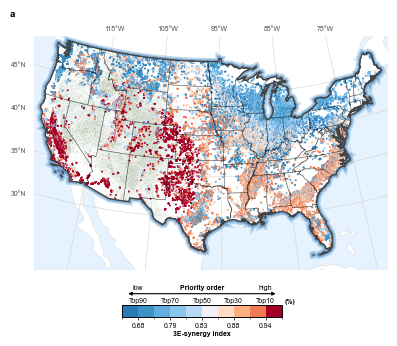

In [164]:
fig_geo2, ax_map = plot_ccd_optimized_global_style_with_dem(df_pixel_optimized_data, us_states_4326, dem_us, us_nation)
fig_geo2.savefig("figure/US_figure/ccd_optimized_with_dem_300dpi.png", dpi=300)
fig_geo2.savefig("figure/US_figure/ccd_optimized_with_dem_300dpi.pdf" ,dpi=300)

# 2、Radar Plot

## 2.1 Calculation of Expectations

In [97]:
import numpy as np 
import pandas as pd 

'''
指针：Result第一段有关政策期望产出
数据：主要相关各个维度的排序方案以及期望产出
计算：
'''


df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_analysis


# 环境维度的变量
env_data = df_analysis[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()

# 碳减排维度的变量

emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit','area_m2']].copy()
emission_data = emission_data.rename(columns={'Expectation_net_benefit': 'Expectation_net_benefit'})

# 经济维度的变量
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index().rename(columns={'net_npv_usd': 'avg_npv'})

# 协同指数的变量
coordinate_data = df_analysis[['lat', 'lon', 'ccd_optimized']].copy()

# 合并所有变量（增加协同指数维度）
merged_data_for_plot = env_data.merge(emission_data, on=['lat', 'lon'], how='outer') \
                      .merge(avg_npv, on=['lat', 'lon'], how='outer') \
                      .merge(coordinate_data, on=['lat', 'lon'], how='outer')




In [100]:
# 计算各排序方案的期望值

import numpy as np 
import pandas as pd 
from scipy import stats

def calculate_integration_scores_with_cv_and_ccd(merged_data_for_plot, confidence_level=0.95):
    """
    计算各个维度优先区方案的平均效率、变异系数和置信区间
    增加基于 ccd_optimized 的排序统计
    优化：统一列名，消除NaN
    """
    
    variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score', 'Environmental'),
        ('Expectation_net_benefit', 'Emission Mitigation', 't', 'Emission'),
        ('avg_npv', 'Economic Feasibility', 'USD', 'Economic'),
        ('ccd_optimized', 'Coordination Index', 'CCD', 'Coordination')
    ]
    
    area_values = merged_data_for_plot['area_m2'].values / 10000  # ha
    total_area = area_values.sum()
    
    def percentage_to_01(pct): 
        return pct / 100.0
    
    def calculate_integral(x, y):
        if len(x) < 2: 
            return 0.0
        if x[0] > x[-1]:
            x = x[::-1]
            y = y[::-1]
        return np.trapz(y, x)
    
    all_integrals = {}
    
    for variable_name, variable_label, unit, short_name in variables:
        dens = merged_data_for_plot[variable_name].values.astype(float)
        if variable_name == 'Expectation_net_benefit':
            dens = dens / 0.27
        total_vals = dens * area_values
        integrals = {}
        idx_sort = np.argsort(total_vals)[::-1]
        cum_ben = np.cumsum(total_vals[idx_sort])
        cum_pct = np.arange(1, len(cum_ben) + 1) / len(cum_ben) * 100
        cum_ben = np.concatenate([[0], cum_ben])
        cum_pct = np.concatenate([[0], cum_pct])
        x01 = percentage_to_01(cum_pct)
        integral_main = calculate_integral(x01, cum_ben) / total_area
        integrals[short_name] = integral_main
        for other_var_name, other_var_label, _, other_short_name in variables:
            if other_var_name == variable_name:
                continue
            other_dens = merged_data_for_plot[other_var_name].values.astype(float)
            if other_var_name == 'Expectation_net_benefit':
                other_dens = other_dens / 0.27
            other_total = other_dens * area_values
            idx_cross = np.argsort(other_total)[::-1]
            cross_cum_ben = np.cumsum(total_vals[idx_cross])
            cross_cum_pct = np.arange(1, len(cross_cum_ben) + 1) / len(cross_cum_ben) * 100
            cross_cum_ben = np.concatenate([[0], cross_cum_ben])
            cross_cum_pct = np.concatenate([[0], cross_cum_pct])
            x01 = percentage_to_01(cross_cum_pct)
            integral_cross = calculate_integral(x01, cross_cum_ben) / total_area
            integrals[other_short_name] = integral_cross
        all_integrals[variable_name] = integrals
    
    sort_methods = ['Environmental', 'Emission', 'Economic', 'Coordination']
    results = []
    alpha = 1 - confidence_level
    
    for variable_name, variable_label, unit, short_name in variables:
        integrals = all_integrals[variable_name]
        values = [integrals[method] for method in sort_methods]
        is_economic = variable_label.strip().startswith("Economic Feasibility")
        if is_economic:
            values = [val / 1000 for val in values]  # 转换为K thousand
        values_array = np.array(values)
        n = len(values_array)
        mean_val = np.mean(values_array)
        std_val = np.std(values_array, ddof=1)
        cv = (std_val / mean_val) if mean_val != 0 else 0

        sem = std_val / np.sqrt(n)
        df_freedom = n - 1
        t_critical = stats.t.ppf(1 - alpha/2, df_freedom)
        margin_of_error = t_critical * sem
        ci_lower = mean_val - margin_of_error
        ci_upper = mean_val + margin_of_error
        relative_error = (margin_of_error / abs(mean_val) * 100) if mean_val != 0 else np.inf

        result_row = {
            'Target': variable_label,
            'Variable_Name': variable_name,
            'Unit': unit,
        }
        for method, val in zip(sort_methods, values):
            result_row[f'Sort_by_{method}'] = val
        result_row['Mean'] = mean_val
        result_row['±Error'] = margin_of_error
        result_row['Mean±Error'] = f"{mean_val:.6e} ± {margin_of_error:.6e}" if not is_economic else f"{mean_val:.2f} ± {margin_of_error:.2f}"
        result_row['CI_Lower'] = ci_lower
        result_row['CI_Upper'] = ci_upper
        result_row['Std'] = std_val
        result_row['CV'] = cv
        result_row['Relative_Error_%'] = relative_error
        result_row['Sample_Size'] = n
        results.append(result_row)
    
    results_df = pd.DataFrame(results)
    return results_df

# 执行分析
results_df = calculate_integration_scores_with_cv_and_ccd(merged_data_for_plot, confidence_level=0.95)

# 显示完整的DataFrame（无NaN）
display(results_df)

,Target,Variable_Name,Unit,Sort_by_Environmental,Sort_by_Emission,Sort_by_Economic,Sort_by_Coordination,Mean,±Error,Mean±Error,CI_Lower,CI_Upper,Std,CV,Relative_Error_%,Sample_Size
0,Environmental Suitability,predicted_prob,Score,0.472343,0.410094,0.398750,0.446000,0.431797,0.053638,4.317969e-01 ± 5.363794e-02,0.378159,0.485435,0.033709,0.078066,12.422029,4
1,Emission Mitigation,Expectation_net_benefit,t,9010.016780,9670.772218,9596.394401,9520.660006,9449.460851,476.259408,9.449461e+03 ± 4.762594e+02,8973.201444,9925.720259,299.303970,0.031674,5.040070,4
2,Economic Feasibility,avg_npv,USD,-75.449503,62.717409,74.787093,26.428256,22.120813,108.547164,22.12 ± 108.55,-86.426350,130.667977,68.216179,3.083801,490.701500,4
3,Coordination Index,ccd_optimized,CCD,0.437282,0.441661,0.436541,0.450104,0.441397,0.009911,4.413970e-01 ± 9.911200e-03,0.431486,0.451308,0.006229,0.014111,2.245416,4


## 2.2 Helper

In [102]:
def _interp_radius_at(theta, angs, rads):
    """在多边形上插值：给定角 theta，返回该角度处外框线(边)的半径"""
    import numpy as np
    angs = np.asarray(angs, dtype=float)
    rads = np.asarray(rads, dtype=float)
    angs_ext = np.concatenate([angs, [angs[0] + 2*np.pi]])
    rads_ext = np.concatenate([rads, [rads[0]]])
    th = float(theta)
    if th < angs_ext[0]:
        th += 2*np.pi
    i = np.searchsorted(angs_ext, th, side='right') - 1
    i = int(np.clip(i, 0, len(angs_ext) - 2))
    a0, a1 = angs_ext[i], angs_ext[i+1]
    t = (th - a0) / (a1 - a0 + 1e-12)
    return rads_ext[i] + t * (rads_ext[i+1] - rads_ext[i])

def place_value_label_toward(ax, vertex_ang, vertex_r, text, *,
                             target_theta_deg,
                             base_angles, base_norm,
                             inner_radius=0.80,
                             ring_margin=0.03,        # 与内环的最小距离(到文本外沿)
                             poly_margin=0.02,        # 与多边形外框线的最小径向距离
                             min_point_gap=0.03,      # 与顶点最小径向距离(考虑marker)
                             radial_shift=-0.04,      # 相对顶点的默认径向位移(负=向内)
                             fontsize=5, marker_size_pt=6):
    """
    将数值文本放到“向 target_theta_deg 方向”的位置，保持水平、黑色、无白底，
    并满足与顶点/外框线/内圆环的安全间距。
    """
    import numpy as np
    fp = FontProperties(family="Arial", size=fontsize, weight="bold")

    # 目标角（绝对极角）
    theta = np.deg2rad(float(target_theta_deg))

    # --- 像素换算(径向/切向) ---
    trans = ax.transData
    dpi = ax.figure.dpi
    p0 = trans.transform((theta, vertex_r))
    p_r1 = trans.transform((theta, vertex_r + 1.0))      # 径向 +1
    p_t1 = trans.transform((theta + 1.0, vertex_r))      # 角向 +1 rad
    px_per_dr     = np.hypot(*(p_r1 - p0)) or 1.0
    px_per_dtheta = np.hypot(*(p_t1 - p0)) or 1.0

    # 文本宽/高（pt→px）
    tp = TextPath((0, 0), text, prop=fp)
    w_pt = tp.get_extents().width
    h_pt = tp.get_extents().height
    half_w_px = (w_pt * dpi / 72.0) / 2.0
    half_h_px = (h_pt * dpi / 72.0) / 2.0
    half_h_dr = half_h_px / px_per_dr
    half_w_rad = half_w_px / px_per_dtheta

    # 顶点 marker 半径(转径向单位)
    marker_rad_px = (marker_size_pt / 2.0) * dpi / 72.0
    marker_rad_dr = marker_rad_px / px_per_dr

    # 径向安全范围（文本外沿不能碰内环；不能小于0）
    r_min = 0.02 + half_h_dr
    r_max = inner_radius - ring_margin - half_h_dr
    r_max = max(r_min, r_max)

    # 初始半径：在顶点基础上做默认径向位移
    r_tgt = np.clip(vertex_r + radial_shift, r_min, r_max)

    # 与“顶点”的最小径向间隙（包含 marker 和文本半高）
    min_gap_dr = max(min_point_gap, marker_rad_dr + 0.01) + half_h_dr
    if abs(r_tgt - vertex_r) < min_gap_dr:
        if radial_shift < 0:
            r_tgt = max(vertex_r - min_gap_dr, r_min)
        else:
            r_tgt = min(vertex_r + min_gap_dr, r_max)

    # 与“多边形外框线”的最小径向间隙
    r_edge = _interp_radius_at(theta, base_angles, base_norm)
    need_gap = poly_margin + half_h_dr
    if abs(r_tgt - r_edge) < need_gap:
        # 远离外框线：按默认方向(向内)优先
        if (r_tgt <= r_edge):
            r_tgt = max(r_edge - need_gap, r_min)
        else:
            r_tgt = min(r_edge + need_gap, r_max)

    # 最终放置（水平、黑字、无白底）
    ax.text(theta, r_tgt, text,
            ha='center', va='center',
            fontsize=fontsize, fontweight='bold', color='black',
            rotation=0, rotation_mode='anchor', zorder=9)


def draw_text_on_arc(ax, text, theta_center, radius,
                     fontproperties=None, letter_spacing=1.0,
                     fit_to_segment=True,
                     segment_span_deg=120, segment_margin_deg=12,
                     radius_offset=0.0):
    """
    在极坐标圆弧上按曲率绘制文字（整段统一方向/翻转，逐字沿切线）。
      - 上半圆(0≤θc≤π)：顺时针排布（角度递减），不翻转
      - 下半圆(π<θc<2π)：逆时针排布（角度递增），整体 +180° 翻转
    radius_offset: 控制文字距离圆心的偏移量（正值向外，负值向内）
    """
    if fontproperties is None:
        fontproperties = FontProperties(family="Arial", size=6, weight="bold")

    # 1) 逐字测宽（pt->px）
    dpi = ax.figure.dpi
    glyph_px = []
    spacing_factor = 1.1  # 原为1.0，适当加大
    for ch in text:
        if ch == ' ':
            space_w_pt = 0.35 * fontproperties.get_size()
            glyph_px.append(space_w_pt * dpi / 72.0 * letter_spacing * spacing_factor)
            continue
        tp = TextPath((0, 0), ch, prop=fontproperties)
        w_pt = tp.get_extents().width
        glyph_px.append(max(0.01, w_pt) * dpi / 72.0 * letter_spacing * spacing_factor)
    total_px = sum(glyph_px)

    # 2) px/rad 换算
    t0 = float(theta_center)
    p0 = ax.transData.transform((t0, radius))
    p1 = ax.transData.transform((t0 + 1.0, radius))  # +1 rad
    px_per_rad = np.hypot(*(p1 - p0)) or 1.0

    # 3) 超长则压缩到扇段宽度内
    if fit_to_segment:
        max_span_rad = np.deg2rad(max(5.0, segment_span_deg - 2*segment_margin_deg))
        need_rad = total_px / px_per_rad
        if need_rad > max_span_rad:
            scale = max_span_rad / need_rad
            glyph_px = [w * scale for w in glyph_px]
            total_px = sum(glyph_px)

    # 4) 以中心角判断半圆与翻转（整段一次性）
    theta_mod = t0 % (2*np.pi)
    on_upper = (0.0 <= theta_mod <= np.pi)
    flip_whole = (theta_mod > np.pi)          # 仅下半圆整体翻转
    step_sign  = (-1.0 if on_upper else +1.0) # 上半递减, 下半递增

    # 布局起点（让整段以中心角居中）
    start_theta = t0 - step_sign * (total_px / (2.0 * px_per_rad))

    # 5) 逐字绘制（沿切线；整段统一翻转）
    cursor = start_theta
    for wpx, ch in zip(glyph_px, text):
        theta_mid = cursor + step_sign * (wpx / (2.0 * px_per_rad))
        deg = np.degrees(theta_mid)

        rot = deg - 90.0
        if flip_whole:
            rot += 180.0

        # 这里控制向圆心移动距离：radius + radius_offset
        txt = ax.text(theta_mid, radius + radius_offset, ch,
                      fontproperties=fontproperties,
                      ha='center', va='center',
                      rotation=rot, rotation_mode='anchor',
                      clip_on=True, zorder=10)
        # txt.set_path_effects([pe.withStroke(linewidth=1.5, foreground='white')])

        cursor += step_sign * (wpx / px_per_rad)

## 2.3 Main Rader

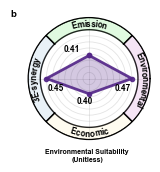

已生成 predicted_prob 的积分雷达图


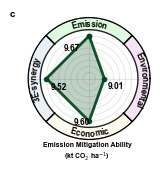

已生成 Expectation_net_benefit 的积分雷达图


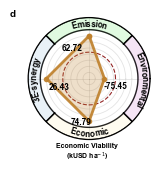

已生成 avg_npv 的积分雷达图
所有积分雷达图生成完成！


In [162]:
import os
from matplotlib.textpath import TextPath
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as pe




def create_integration_radar_charts(results_df):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.font_manager import FontProperties
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })
    os.makedirs("figure/US_figure", exist_ok=True)

    
    # ===== 变量定义 =====
    variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score'),
        ('Expectation_net_benefit', 'Emission Mitigation Ability', 'Gt '),
        ('avg_npv', 'Economic Viability', 'USD')
    ]
    env_color = '#542788'
    carbon_color = '#00441b'
    economic_color = '#bf812d'
    coordination_color = '#3c6b99'
    variable_colors = {
        'predicted_prob': env_color,
        'Expectation_net_benefit': carbon_color,
        'avg_npv': economic_color,
        'ccd_optimized': coordination_color
    }
    panel_labels = ['b', 'c', 'd']
    categories = ['Emission', 'Environmental', 'Economic', 'Coordination']
    custom_angles = [np.pi/2, 0, 3*np.pi/2, np.pi]
    sort_methods = categories

    all_integrals = {}
    for var, label, unit in variables:
        subset = results_df[results_df['Variable_Name'] == var].iloc[0]
        # If method is 'Coordination', rename it to '3E-synergy'
        all_integrals[var] = {
            ('3E-synergy' if method == 'Coordination' else method): subset[f'Sort_by_{method}']
            for method in sort_methods
        }
        

    for idx, (variable_name, variable_label, unit) in enumerate(variables):
        fig, ax = plt.subplots(1, 1, figsize=(40/25.4, 40/25.4), subplot_kw=dict(projection='polar'))
        plt.subplots_adjust(top=0.95, bottom=0.15)  # 图像上移一点
        integrals = all_integrals[variable_name]

        values = [
            integrals['Emission'],
            integrals['Environmental'],
            integrals['Economic'],
            integrals['3E-synergy']
        ]
        # 数量级显示
        if variable_name == 'predicted_prob':
            display_values = [v for v in values]; unit_suffix = '\n(Unitless)'
        elif variable_name == 'Expectation_net_benefit':
            display_values = [v/1e3 for v in values]; unit_suffix = '\n(kt CO$_2$ ha$^{-1}$)'
        elif variable_name == 'avg_npv':
            display_values = [v for v in values]; unit_suffix = '\n(kUSD ha$^{-1}$)'
        else:
            display_values = values; unit_suffix = ''
        
        vmin = vmax = None
        if display_values:
            vmin, vmax = min(display_values), max(display_values)
            if vmax > vmin:
                vr = vmax - vmin
                center_offset = vmin - 0.3 * vr
                arange = (vmax - center_offset) / 0.7
                norm_vals = [(v - center_offset) / arange for v in display_values]
                norm_vals = [max(0, min(0.7, v)) for v in norm_vals]
                mn = min(norm_vals)
                if mn < 0.2:
                    s = 0.25 / max(mn, 1e-9)
                    norm_vals = [min(0.7, v*s) for v in norm_vals]
            else:
                norm_vals = [0.5] * len(display_values)
        else:
            norm_vals = [0] * len(categories)

        # 角度/闭合：保留“未闭合”版本用于顶点标注
        base_angles = custom_angles.copy()
        base_norm   = norm_vals[:]
        angles_closed = base_angles + base_angles[:1]
        norm_closed   = base_norm + base_norm[:1]

        # ===== 角度刻度（不显示文字，但用于绘制辐射网格）=====
        ax.set_xticks(base_angles)
        ax.set_xticklabels(['']*len(base_angles))

        # ===== 绘制面/线 =====
        ax.plot(angles_closed, norm_closed, 'o-', linewidth=2,
                color=variable_colors[variable_name], alpha=0.9, zorder=5,markersize=3)
        ax.fill(angles_closed, norm_closed, alpha=0.25,
                color=variable_colors[variable_name], zorder=4)
        outer_radius, inner_radius = 1.0, 0.80

        ring_colors = {
            'Emission': '#90EE90',
            'Environmental': '#DDA0DD',
            'Economic': '#FFF5CC',
            '3E-synergy': '#B3CDE3'
        }

        sector_half = np.deg2rad(45)
        for angle, cat in zip(base_angles, ring_colors.keys()):
            start_angle = angle - sector_half
            end_angle = angle + sector_half
            theta_ring = np.linspace(start_angle, end_angle, 120)
            inner_circle = np.full_like(theta_ring, inner_radius)
            outer_circle = np.full_like(theta_ring, outer_radius)

            ax.plot(theta_ring, inner_circle, 'k-', lw=1.0, alpha=0.85, zorder=2)
            ax.plot(theta_ring, outer_circle, 'k-', lw=1.0, alpha=0.85, zorder=2)
            ax.plot([start_angle, start_angle], [inner_radius, outer_radius], 'k-', lw=1.0, alpha=0.85, zorder=2)
            ax.plot([end_angle, end_angle], [inner_radius, outer_radius], 'k-', lw=1.0, alpha=0.85, zorder=2)

            ring_theta = np.concatenate([theta_ring, theta_ring[::-1]])
            ring_radius = np.concatenate([inner_circle, outer_circle[::-1]])
            ax.fill(ring_theta, ring_radius, color=ring_colors[cat], alpha=0.28, zorder=1)

            draw_text_on_arc(
                ax, cat, theta_center=angle, radius=inner_radius + 0.12,
                fontproperties=FontProperties(family="Arial", size=6, weight="bold"),
                letter_spacing=1.05, fit_to_segment=True,
                segment_span_deg=90, segment_margin_deg=12, radius_offset=-0.02
            )

        target_theta_map = {
            'Emission': 120,
            'Environmental': -15,
            'Economic': 260,
            'Coordination': 195
        }
        radial_shift_map = {
            'Emission': -0.035,
            'Environmental': 0.02,
            'Economic': 0.045,
            'Coordination': -0.015
        }

        for angle, val, r_norm, cat in zip(base_angles, display_values, base_norm, categories):
            label_text = f'{val:.2f}'

            # "Environmental", idx==0 向下移动（数值更负）
            if cat == 'Environmental' and idx == 0:
                radial_shift = -0.01  # 比原-0.1更明显向下
            elif cat == 'Environmental' and idx in [1, 2]:
                radial_shift = 0.2
            elif cat == 'Emission' and idx in [0]:
                radial_shift = 0
            else:
                radial_shift = radial_shift_map.get(cat, -0.02)

            place_value_label_toward(
                ax, angle, r_norm, label_text,
                target_theta_deg=target_theta_map.get(cat, np.degrees(angle)),
                base_angles=base_angles, base_norm=base_norm,
                inner_radius=inner_radius,
                ring_margin=0.03,
                poly_margin=0.02,
                min_point_gap=0.03,
                radial_shift=radial_shift,
                fontsize=6,
                marker_size_pt=6
            )

        ax.set_ylim(0, 1.0)
        radial_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
        ax.set_yticks(radial_levels)
        ax.set_yticklabels([''] * len(radial_levels))
        ax.grid(True, alpha=0.35, linewidth=0.6)
        ax.set_axisbelow(True)

        fig.text(0.01, 0.99, panel_labels[idx], ha='left', va='top', fontsize=7, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)
        fig.text(0.5, 0.02, f'{variable_label}{unit_suffix}',
                 ha='center', va='bottom', fontsize=5, fontweight='bold',
                 transform=fig.transFigure, zorder=100)

        if variable_name == 'avg_npv' and display_values:
            if vmax > vmin:
                vr = vmax - vmin
                center_offset = vmin - 0.3 * vr
                arange = (vmax - center_offset) / 0.7
                zero_norm = (0 - center_offset) / arange
                zero_norm = max(0, min(0.7, zero_norm))
                theta_dense = np.linspace(0, 2 * np.pi, 400)
                ax.plot(theta_dense, np.full_like(theta_dense, zero_norm), '--', color='#800000',
                        linewidth=0.8, alpha=0.85, zorder=3)

        png_path = f"figure/US_figure/integration_radar_{variable_name}_individual.png"
        pdf_path = f"figure/US_figure/integration_radar_{variable_name}_individual.pdf"
        # 将背景设置为透明
        fig.savefig(png_path, dpi=300, facecolor='none', transparent=True, pad_inches=0.08)
        fig.canvas.draw()
        fig.savefig(pdf_path, dpi=300, facecolor='none', transparent=True, pad_inches=0.08)
        plt.show()
        plt.close(fig)

        print(f"已生成 {variable_name} 的积分雷达图")

    print("所有积分雷达图生成完成！")
    return fig, ax


fig, ax = create_integration_radar_charts(results_df)


In [131]:
results_df

,Target,Variable_Name,Unit,Sort_by_Environmental,Sort_by_Emission,Sort_by_Economic,Sort_by_Coordination,Mean,±Error,Mean±Error,CI_Lower,CI_Upper,Std,CV,Relative_Error_%,Sample_Size
0,Environmental Suitability,predicted_prob,Score,0.472343,0.410094,0.398750,0.446000,0.431797,0.053638,4.317969e-01 ± 5.363794e-02,0.378159,0.485435,0.033709,0.078066,12.422029,4
1,Emission Mitigation,Expectation_net_benefit,t,9010.016780,9670.772218,9596.394401,9520.660006,9449.460851,476.259408,9.449461e+03 ± 4.762594e+02,8973.201444,9925.720259,299.303970,0.031674,5.040070,4
2,Economic Feasibility,avg_npv,USD,-75.449503,62.717409,74.787093,26.428256,22.120813,108.547164,22.12 ± 108.55,-86.426350,130.667977,68.216179,3.083801,490.701500,4
3,Coordination Index,ccd_optimized,CCD,0.437282,0.441661,0.436541,0.450104,0.441397,0.009911,4.413970e-01 ± 9.911200e-03,0.431486,0.451308,0.006229,0.014111,2.245416,4


# 3、Singel-color

## 3.1 Helper

In [211]:

def _render_terrain(ax, dem_data, usa_bounds_main, transformer):
    """渲染地形"""
    qm = None
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    
    if lon_mask.any() and lat_mask.any():
        lon_idx = np.where(lon_mask)[0]
        lat_idx = np.where(lat_mask)[0]
        
        # 抽稀栅格
        step_x = max(1, len(lon_idx)//1800)
        step_y = max(1, len(lat_idx)//900)
        lon_sub = lon_idx[::step_x]
        lat_sub = lat_idx[::step_y]
        elev = dem_data.squeeze().values[np.ix_(lat_sub, lon_sub)]

        mask = ~np.isnan(elev)
        if mask.any():
            lo = np.nanpercentile(elev, 35)
            elev[elev < lo] = np.nan

            # 地形配色
            terrain_colors = ListedColormap(["#ffffff", "#eef3ef", "#dfe8e0",
                                           "#d2ddcf", "#c7d1c1", "#b7c2af"])
            terrain_colors.set_bad((0, 0, 0, 0))
            qs = np.nanpercentile(elev, [35, 50, 65, 78, 88, 98])
            norm = BoundaryNorm(qs, terrain_colors.N)

            lon_grid, lat_grid = np.meshgrid(dem_lon[lon_sub], dem_lat[lat_sub])
            gx, gy = transformer.transform(lon_grid, lat_grid)            
            qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,
                              shading='auto', alpha=0.55, antialiased=False, zorder=1)
            qm.set_clip_on(True)
    
    return qm


def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """绘制国界线光晕效果"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes



def _draw_background_map(ax, usa_bounds_main):
    """绘制背景地图"""
    try:
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        
        if make_valid is not None:
            helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        else:
            helper_gdf['geometry'] = helper_gdf.geometry.buffer(0)
            
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(ax=ax, facecolor='white', edgecolor='lightgray',
                           linewidth=0.3, alpha=1, zorder=0.5)
    except Exception as e:
        print(f"Helper map error: {e}")

def _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit, var_values, colors):
    """Override: only render the horizontal color bar."""
    pos = ax.get_position()
    left = pos.x0 + 0.25 * pos.width
    bottom = 0.08
    width = 0.45 * pos.width
    height = 0.035

    cax = fig.add_axes([left, bottom, width, height])
    cax.set_in_layout(False)
    cax.set_zorder(50)
    cb = fig.colorbar(scatter, cax=cax, orientation='horizontal')
    cb.set_ticks(var_bins[1::2])

    tick_vals = var_bins[1::2]
    if variable_name == 'avg_npv':
        tick_labels = [f'{v/1_000:.2f}' for v in tick_vals]
    elif variable_name == 'predicted_prob':
        tick_labels = [f'{v:.2f}' for v in tick_vals]
    elif variable_name == 'Expectation_net_benefit':
        tick_labels = [f'{v/1_000:.2f}' for v in tick_vals]
    else:
        tick_labels = [f'{v:.0f}' for v in tick_vals]
    cb.set_ticklabels(tick_labels)

    cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
    cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
    cb.outline.set_linewidth(0.7)

    percentile_labels = [f'Top{p}' for p in range(10, 101, 20)][::-1]
    for loc, label in zip(cb.get_ticks(), percentile_labels):
        x_disp = cax.transData.transform((loc, 0))[0]
        x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
        cax.text(x_frac, 1.3, label, transform=cax.transAxes,
                 ha='center', va='bottom', fontsize=5, clip_on=False,
                 bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7, edgecolor='none'))
    cax.text(1.02, 1.3, '(%)', ha='center', va='bottom', fontsize=5,
             fontweight='bold', transform=cax.transAxes,
             bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7, edgecolor='none'))

    for ch in cax.get_children():
        try:
            ch.set_clip_path(cax.patch)
        except Exception:
            pass

    if variable_name == 'net_npv_usd':
        unit_display = f'Economic viability {unit} '
    elif variable_name == 'Expectation_net_benefit':
        unit_display = f'{unit} '
    else:
        unit_display = f'Economic viability '

    cax.text(0.5, -1.11, unit_display, ha='center', va='top', fontsize=5,
             fontweight='bold', transform=cax.transAxes,
             bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7, edgecolor='none'))
    return cax, cb


def _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格，标签显示在上方和右方（曲线网格）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线，裁剪到地图区域
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在顶部边界寻找交点
        top_edge = LineString([(xmin, ymax), (xmax, ymax)])
        intersection = line.intersection(top_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                xticks.append(intersection.x)
                ax.text(intersection.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7, 
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择最左侧的
                points = list(intersection.geoms)
                if points:
                    x_coords = [p.x for p in points]
                    min_x_idx = np.argmin(x_coords)
                    xticks.append(points[min_x_idx].x)
                    ax.text(points[min_x_idx].x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                           ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7, 
                                   edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧边界寻找交点
        left_edge = LineString([(xmin, ymin), (xmin, ymax)])
        intersection = line.intersection(left_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                yticks.append(intersection.y)
                ax.text(xmin - (xmax - xmin) * 0.02, intersection.y, f"{int(round(lat))}°N",
                       ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7,
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择中间的
                points = list(intersection.geoms)
                if points:
                    mid_idx = len(points) // 2
                    yticks.append(points[mid_idx].y)
                    ax.text(xmin - (xmax - xmin) * 0.02, points[mid_idx].y, f"{int(round(lat))}°N",
                           ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7,
                                   edgecolor='none'))
    """绘制经纬度网格，标签显示在上方和左侧（曲线网格，去除右侧标签）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])  
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 在顶部显示标签
        p = _choose_point_on_edge(line.intersection(top))
        if p is None:
            p = _choose_point_on_edge(line.intersection(bottom))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                # 在上方显示标签
                ax.text(p.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7, 
                               edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧显示标签（不在右侧）
        p = _choose_point_on_edge(line.intersection(left))
        if p is not None:
            yticks.append(p.y)
            ax.text(xmin - (xmax - xmin) * 0.02, p.y, f"{int(round(lat))}°N",
                   ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7,
                           edgecolor='none'))

## 3.2 Singe-color

In [212]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import matplotlib as mpl
import matplotlib.ticker as mticker

def plot_single_variable(
    merged_data_for_plot, 
    us_states_gdf, 
    dem_data, 
    variable_name,
    title=None, 
    unit=None, 
    colors=None, 
    cmap_type='sequential',
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False  
):
    """
    绘制单变量地图，简化版本
    
    Parameters:
    -----------
    merged_data_for_plot : DataFrame
        包含经纬度和变量数据的数据框
    us_states_gdf : GeoDataFrame
        美国州界数据
    dem_data : xarray.Dataset
        DEM地形数据
    variable_name : str
        要绘制的变量名
    title : str, optional
        图表标题
    unit : str, optional
        变量单位
    colors : list, optional
        颜色列表
    cmap_type : str, default 'sequential'
        颜色映射类型
    add_north_arrow_and_scalebar : bool, default True
        是否添加指北针和比例尺
    add_embedding_points : bool, default False
        是否添加嵌入点
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })


    # 创建更大的图形和坐标轴
    fig, ax = plt.subplots(1, 1, figsize=(58/25.4, 40/25.4))  
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')

    # ==================== 2. 地理边界设置 ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理州界数据
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    
    # 处理国界线
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 3. 坐标变换设置 ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 4. 地图范围计算 ====================
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds

    # 减小边界，让图幅更大
    margin_x = (xmax - xmin) * 0.02  
    margin_y = (ymax - ymin) * 0.02
    colorbar_space = (ymax - ymin) * 0.05  
    
    xmin = xmin - margin_x
    xmax = xmax + margin_x
    ymin = ymin - margin_y - colorbar_space
    ymax = ymax + margin_y

    # 设置坐标轴位置和范围 - 图像整体向上移动，比例不变
    ax.set_position([0.1, 0.05, 0.8, 0.8])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 5. 数据坐标转换 ====================
    x_proj, y_proj = transformer.transform(merged_data_for_plot['lon'].values, 
                                          merged_data_for_plot['lat'].values)

    # ==================== 6. 地形渲染 ====================
    qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)

    # ==================== 7. 地图元素绘制 ====================
    # 绘制国界线光晕效果
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制州界
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 8. 取消坐标轴和网格 ====================
    # 移除坐标轴边框
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    lon_ticks = np.arange(-115, -65, 10)
    lat_ticks = [ 30,35,40,45]
    
    # 绘制曲线网格线（标签显示在上方）
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 9. 背景地图 ====================
    # _draw_background_map(ax, usa_bounds_main)

    # ==================== 10. 数据可视化 ====================
    var_values = np.round(np.asarray(merged_data_for_plot[variable_name].values, dtype=float), 3)
    var_bins = np.nanpercentile(var_values, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    cmap = LinearSegmentedColormap.from_list(f"{variable_name}_cmap", colors, N=11)
    norm = BoundaryNorm(var_bins, ncolors=cmap.N)
    
    scatter = ax.scatter(x_proj, y_proj, c=var_values, cmap=cmap, norm=norm,
                        s=0.3, alpha=1, edgecolors='none', zorder=5)

    # ==================== 11. 颜色条（传入var_values用于绘制分布图）====================
    # _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit, var_values, colors)
    # ==================== 12. 最终处理 ====================
    fig.canvas.draw()          
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    return fig, ax

C:\Users\zpy10\AppData\Local\Temp\ipykernel_50148\1647133101.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


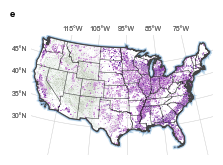

C:\Users\zpy10\AppData\Local\Temp\ipykernel_50148\1647133101.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


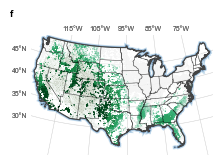

C:\Users\zpy10\AppData\Local\Temp\ipykernel_50148\1647133101.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


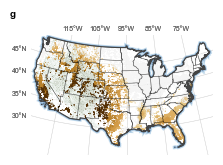

所有图片生成完成！


In [213]:

variables_config = [
    {
        'name': 'predicted_prob',
        'title': 'Environmental Potential',
        'unit': 'Probability',
        # 采用单色渐变，逐渐变深为紫色
        'colors': [
            '#f5f5f5',
            '#f5f5f5',
            '#f5f5f5',
            '#f5f5f5',
            '#f5f5f5',
            '#ce93d8',
            '#ba68c8',
            '#ab47bc',
            '#9c27b0',
            '#7b1fa2',
            '#4a148c'
        ],
        'filename': 'environmental score'
    },
    {
        'name': 'Expectation_net_benefit', 
        'title': 'Carbon Mitigation Potential',
        'unit': 'kt CO$_2$ ha$^{-1}$',
        # 采用单色渐变，逐渐变深为绿色，到'#00441b'
        'colors': [
            '#f5f5f5',
            '#f5f5f5',
            '#f5f5f5',
            '#f5f5f5',
            '#f5f5f5',
            '#43b984',
            '#2fa76a',
            '#219150',
            '#005824',
            '#00441b'
        ],

        'filename': 'carbon_mitigation_potential'
    },
    {
        'name': 'avg_npv',
        'title': 'Economic Potential', 
        'unit': 'k USD ha$^{-1}$',
        'colors': [
            '#f5f5f5',
            '#f5f5f5',
            '#f5f5f5',
            '#f5f5f5',
            '#f5f5f5',
            '#e5c684', '#ddaf62', '#d29b46', '#ba832c', '#a36d1c', '#543005'
        ],
        'filename': 'economic_potential'
    }
]

# 生成三个单独的图
panel_labels = ['e', 'f', 'g']

for i, var_config in enumerate(variables_config):
    try:
        add_north_arrow_and_scalebar = (i == 0)
        add_embedding_points = False

        fig, ax = plot_single_variable(
            merged_data_for_plot, 
            us_states_4326, 
            dem_us,
            var_config['name'],
            var_config['title'],
            var_config['unit'],
            var_config['colors'],
            add_north_arrow_and_scalebar=add_north_arrow_and_scalebar,
            add_embedding_points=add_embedding_points
        )

        fig.text(
            0.01, 0.99, panel_labels[i], ha='left', va='top', fontsize=7, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.2, lw=0), zorder=100
        )

        # 保存图片
        filename_png = f"figure/US_figure/{var_config['filename']}_priority_300dpi.png"
        filename_pdf = f"figure/US_figure/{var_config['filename']}_priority_300dpi.pdf"
        
        fig.savefig(filename_png, dpi=300, facecolor='white')
        fig.canvas.draw()
        fig.savefig(filename_pdf, dpi=300, facecolor='white')

        plt.show()
        plt.close(fig)

    except Exception as e:
        print(e)
        continue

print("所有图片生成完成！")

# 4、Curve Plot

=== 数据预处理：使用merged_data_for_plot ===
数据行数: 70337
总面积: 4703357.18 公顷


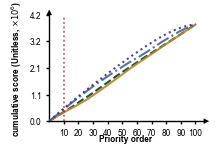

已生成 predicted_prob 的交叉目标分析图


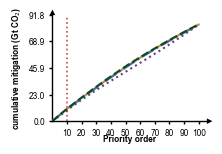

已生成 Expectation_net_benefit 的交叉目标分析图


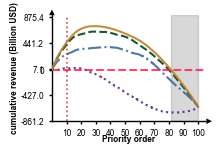

已生成 avg_npv 的交叉目标分析图
所有交叉目标分析图生成完成！


In [237]:
def create_cross_target_analysis_individual(merged_data_for_plot):
    """
    创建交叉目标分析图，逐个输出三个子图，参照plot_single_variable_nature_style的尺寸设计
    直接使用merged_data_for_plot作为数据源
    """
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch, FancyArrowPatch
    
    # 设置字体参数，参考plot_single_variable_nature_style
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })

    # 定义四个变量
    variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score'),
        ('Expectation_net_benefit', 'Emission Mitigation', 'Mg C'),
        ('avg_npv', 'Economic Feasibility', 'USD'),
        ('ccd_optimized', 'Coordination Index', 'Index')
    ]
    plot_variables = variables[:3]

    # 修改颜色方案
    env_color = '#542788'   # 紫色
    carbon_color = '#00441b'  # 绿色
    economic_color = '#bf812d'  # 棕色
    coordination_color = '#3c6b99'  # 蓝灰

    # 映射变量名到颜色
    variable_colors = {
        'predicted_prob': env_color,
        'Expectation_net_benefit': carbon_color,
        'avg_npv': economic_color,
        'ccd_optimized': coordination_color
    }

    # 映射变量名到线型
    variable_linestyles = {
        'predicted_prob': ':',        # 点线
        'Expectation_net_benefit': '--',  # 虚线
        'avg_npv': '-',               # 实线
        'ccd_optimized': '-.'         # 点划线
    }

    # 面板标签
    panel_labels = ['', '', '']

    # ==================== 数据预处理 ====================
    print("=== 数据预处理：使用merged_data_for_plot ===")
    print(f"数据行数: {len(merged_data_for_plot)}")
    
    # 检查必要的列是否存在
    required_cols = ['lat', 'area_m2'] + [var[0] for var in variables]
    missing_cols = [col for col in required_cols if col not in merged_data_for_plot.columns]
    if missing_cols:
        raise ValueError(f"缺少必要的列: {missing_cols}")
    
    # 计算总面积
    area_values = merged_data_for_plot['area_m2'].values / 10000  # 转换为公顷
    print(f"总面积: {np.sum(area_values):.2f} 公顷")

    # 逐个生成图片
    for idx, (variable_name, variable_label, unit) in enumerate(plot_variables):
        # 参照plot_single_variable_nature_style的figsize，但调整为适合折线图的尺寸
        # fig, ax = plt.subplots(1, 1, figsize=(1.97, 1.6))  # 50mm width ≈ 1.97 inch
        # ax.set_title(variable_label, fontsize=7, fontweight='bold', ha='center', va='top', pad=12)
        fig, ax = plt.subplots(1, 1, figsize=(52/25.4, 36/25.4))  # 60mm x 40mm

        # 获取当前变量的数据
        benefit_density_values = merged_data_for_plot[variable_name].values
        if variable_name == 'Expectation_net_benefit':
            benefit_density_values = benefit_density_values / 0.27 

        if variable_name == 'predicted_prob':
            benefit_total_values = benefit_density_values * area_values
        else:
            benefit_total_values = benefit_density_values * area_values

        # 当前变量曲线（目标曲线）
        target_sorted_indices = np.argsort(benefit_total_values)[::-1]
        target_cumulative_benefits = np.cumsum(benefit_total_values[target_sorted_indices])
        target_cumulative_percentage = np.arange(1, len(target_cumulative_benefits) + 1) / len(target_cumulative_benefits) * 100
        target_cumulative_benefits = np.concatenate([[0], target_cumulative_benefits])
        target_cumulative_percentage = np.concatenate([[0], target_cumulative_percentage])

        # 其他两个变量的曲线（交叉曲线）
        cross_curves_data = []
        for other_var_name, other_var_label, other_unit in variables:
            if other_var_name != variable_name:
                other_density_values = merged_data_for_plot[other_var_name].values
                if other_var_name == 'Expectation_net_benefit':
                    other_density_values = other_density_values / 0.27 
                if other_var_name == 'predicted_prob':
                    other_total_values = other_density_values * area_values
                else:
                    other_total_values = other_density_values * area_values
                
                cross_sorted_indices = np.argsort(other_total_values)[::-1]
                cross_cumulative_benefits = np.cumsum(benefit_total_values[cross_sorted_indices])
                cross_cumulative_percentage = np.arange(1, len(cross_cumulative_benefits) + 1) / len(cross_cumulative_benefits) * 100
                cross_cumulative_benefits = np.concatenate([[0], cross_cumulative_benefits])
                cross_cumulative_percentage = np.concatenate([[0], cross_cumulative_percentage])
                
                cross_curves_data.append({
                    'label': f'By {other_var_label.split(" ")[0]}',
                    'color': variable_colors[other_var_name],
                    'linestyle': variable_linestyles[other_var_name],
                    'percentage': cross_cumulative_percentage,
                    'benefits': cross_cumulative_benefits,
                    'var_name': other_var_name
                })

        # 绘制目标曲线（当前变量）
        target_color_current = variable_colors[variable_name]
        target_linestyle_current = variable_linestyles[variable_name]
        ax.plot(target_cumulative_percentage, target_cumulative_benefits,
                 color=target_color_current, linewidth=1.5, alpha=0.9, 
                 linestyle=target_linestyle_current, zorder=8,
                 label=f'{variable_label.split(" ")[0]}')

        # 绘制交叉曲线（其他两个变量）
        for curve in cross_curves_data:
            ax.plot(curve['percentage'], curve['benefits'],
                     color=curve['color'], linewidth=1.5, alpha=0.9, 
                     linestyle=curve['linestyle'], zorder=6,
                     label=curve['label'])

        # 特殊处理NPV的Y=0线和阴影
        if variable_name == 'avg_npv':
            ax.axhline(y=0, color='#FF1744', linestyle='--', linewidth=1.5, alpha=0.8, zorder=7,
                      label='Break-even Line')
            
            # 找到Economic曲线与Y=0轴的交点
            economic_negative_mask = target_cumulative_benefits < 0
            if np.any(economic_negative_mask):
                first_negative_idx = np.where(economic_negative_mask)[0][0]
                if first_negative_idx > 0:
                    x1, y1 = target_cumulative_percentage[first_negative_idx-1], target_cumulative_benefits[first_negative_idx-1]
                    x2, y2 = target_cumulative_percentage[first_negative_idx], target_cumulative_benefits[first_negative_idx]
                    
                    if y2 != y1:
                        intersection_x = x1 + (x2 - x1) * (0 - y1) / (y2 - y1)
                        ax.axvspan(intersection_x, 100, color='gray', alpha=0.3, zorder=1, 
                                   label='Negative Region')

        # X轴标签
        ax.text(0.5, -0.13, 'Priority order', transform=ax.transAxes, ha='center', va='top',
                fontsize=6, fontweight='bold')

        # 设置X轴刻度
        key_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        xtick_positions = [p for p in key_percentages if p >= 10]
        xtick_labels = [f'{p}' for p in xtick_positions]
        ax.set_xticks(xtick_positions)
        ax.set_xticklabels(xtick_labels, ha='center', fontsize=6)
        ax.set_xlim(0, 105)

        # 设置Y轴范围和格式化，并减少y轴刻度数量
        all_curves_min = target_cumulative_benefits.min()
        all_curves_max = target_cumulative_benefits.max()
        for curve in cross_curves_data:
            all_curves_min = min(all_curves_min, curve['benefits'].min())
            all_curves_max = max(all_curves_max, curve['benefits'].max())
        
        if variable_name == 'predicted_prob':
            # Environmental: 除以1e6，保留1位小数，显示1e6
            ax.set_ylim(0, all_curves_max * 1.1)
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e6:.1f}'))
            ax.set_ylabel('cumulative score (Unitless, $\\times 10^6$)', fontsize=6, fontweight='bold')
            yticks = np.linspace(0, all_curves_max * 1.1, 5)
            ax.set_yticks(yticks)
        elif variable_name == 'Expectation_net_benefit':
            # Emission: 除以1e9，保留1位小数，显示1e9
            ax.set_ylim(0, all_curves_max * 1.1)
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e9:.1f}'))
            ax.set_ylabel('cumulative mitigation (Gt CO$_2$)', fontsize=6, fontweight='bold')
            yticks = np.linspace(0, all_curves_max * 1.1, 5)
            ax.set_yticks(yticks)
        elif variable_name == 'avg_npv':
            # Economic: 除以1e9，保留1位小数，显示1e9
            y_range = all_curves_max - all_curves_min
            if y_range == 0:
                y_range = abs(all_curves_max) * 0.1
            y_min = all_curves_min - y_range * 0.1
            y_max = all_curves_max + y_range * 0.1
            ax.set_ylim(y_min, y_max*1.05)
            ax.set_ylabel('cumulative revenue (Billion USD)', fontsize=6, fontweight='bold', labelpad=1.2)

            # 生成yticks，并确保0会被标注出来
            yticks = np.linspace(y_min, y_max, 5)
            # 判断0是否已经在yticks里，如果不在，则插入
            if not np.isclose(yticks, 0).any() and (0 > yticks.min()) and (0 < yticks.max()):
                yticks = np.sort(np.append(yticks, 0))
            ax.set_yticks(yticks)
            
            def billion_formatter(x, pos):
                if np.isclose(x, 0):
                    return '0'
                return f'{x/1e9:.1f}'
            ax.yaxis.set_major_formatter(FuncFormatter(billion_formatter))

        # 10%分位线
        ax.axvline(10, color='#B71C1C', linestyle=':', linewidth=1.2, alpha=0.8, zorder=7)
        ax.text(0.10, 1.02, '', transform=ax.transAxes, ha='center', va='bottom', fontsize=5, color='#B71C1C')

        # 轴向箭头
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()
        arrow_x = FancyArrowPatch(
            posA=(x_lim[1], 0),
            posB=(x_lim[1] + (x_lim[1] - x_lim[0]) * 0.06, 0),
            transform=ax.get_xaxis_transform(),
            arrowstyle='simple',
            color='black', linewidth=0, mutation_scale=8, zorder=9
        )
        arrow_x.set_clip_on(False)
        ax.add_patch(arrow_x)

        arrow_y = FancyArrowPatch(
            posA=(0, y_lim[1]),
            posB=(0, y_lim[1] + (y_lim[1] - y_lim[0]) * 0.05),
            transform=ax.get_yaxis_transform(),
            arrowstyle='simple',
            color='black', linewidth=0, mutation_scale=8, zorder=9
        )
        arrow_y.set_clip_on(False)
        ax.add_patch(arrow_y)

        # 网格和样式设置
        # ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)  # 不需要网格，已注释
        ax.set_axisbelow(True)
        
        # 坐标轴样式设置
        ax.tick_params(axis='both', which='major', width=1, size=2, labelsize=6, color='black')
        # 设置坐标轴线的颜色和粗细
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_color('black')

        # 去掉上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # 布局调整 - 参照plot_single_variable_nature_style的坐标轴位置
        ax.set_position([0.2, 0.15, 0.75, 0.75])  
        fig.text(0.01, 1, panel_labels[idx], ha='left', va='top', fontsize=7, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

        # 保存图片
        filename_png = f"figure/US_figure/cross_target_{variable_name}_individual.png"
        filename_pdf = f"figure/US_figure/cross_target_{variable_name}_individual.pdf"
        
        fig.savefig(filename_png, dpi=300, facecolor='white', pad_inches=0.1)
        fig.canvas.draw()
        fig.savefig(filename_pdf, dpi=300, facecolor='white', pad_inches=0.1)
        
        plt.show()
        plt.close(fig)
        
        print(f"已生成 {variable_name} 的交叉目标分析图")

    print("所有交叉目标分析图生成完成！")
    return fig, ax

# 执行函数
fig, ax = create_cross_target_analysis_individual(merged_data_for_plot)

In [214]:
merged_data_for_plot

,lat,lon,predicted_prob,gmm_density,sample_type,Expectation_net_benefit,area_m2,avg_npv,ccd_optimized
0,25.295834,-80.287500,0.902568,2.806133e+19,prediction,4756.489612,776295.361002,411724.028993,0.940305
1,25.437500,-80.537500,0.997976,5.399806e+21,prediction,4098.985904,775385.854124,287052.220262,0.828012
2,25.437500,-80.495834,0.995833,1.508036e+20,prediction,4467.282818,775385.854124,278019.855286,0.882208
3,25.445833,-80.454170,0.990886,1.800785e+16,prediction,4460.638370,775332.207938,272893.696918,0.880366
4,25.445833,-80.404170,0.996591,6.792866e+22,prediction,4486.467516,775332.207938,294800.434504,0.888518
...,...,...,...,...,...,...,...,...,...
70332,48.995834,-99.995834,0.914557,5.692829e+14,prediction,4247.886562,563356.382622,-556486.868714,0.790359
70333,48.995834,-99.987500,0.921603,1.413612e+14,prediction,4312.480812,563356.382622,-562376.609379,0.800732
70334,48.995834,-99.895836,0.872176,3.161397e+13,prediction,4260.343608,563356.382622,-598319.346882,0.757385
70335,48.995834,-99.887500,0.799749,6.767585e+13,prediction,4264.916125,563356.382622,-594934.043507,0.691242


merged_data_for_plot